In [71]:
import pandas as pd
import numpy as np
import dowhy
from dowhy import CausalModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

from tqdm import tqdm

from econml.metalearners import SLearner, XLearner, TLearner
from econml.dml import LinearDML, CausalForestDML
from econml.dr  import DRLearner

import matplotlib.pyplot as plt

import time

from lightgbm import LGBMRegressor, LGBMClassifier

In [3]:
url_inter_train = "https://raw.githubusercontent.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/main/data/ml_earnings_interaction_train.csv"
url_inter_test = "https://raw.githubusercontent.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/main/data/ml_earnings_interaction_test.csv"

earning_interaction_train = pd.read_csv(url_inter_train)
earning_interaction_test = pd.read_csv(url_inter_test)

nodes = ["took_a_course", "earnings", "age", "python_proficiency"]
edges = [
    ("took_a_course", "earnings"),
    ("age", "took_a_course"),
    ("age", "earnings"),
    ("python_proficiency", "earnings")
]

gml_string = "graph [directed 1\n"
for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += "]"

model = CausalModel(
    data=earning_interaction_train,
    treatment="took_a_course",
    outcome="earnings",
    effect_modifiers="python_proficiency",
    graph=gml_string
)

In [5]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="backdoor.econml.dr.LinearDRLearner",
    target_units="ate",
    method_params={
        "init_params": {
            # Treatment and outcome models
            "model_propensity": LogisticRegression(),
            "model_regression": LGBMRegressor(n_estimators=1000,
                                              max_depth=10)
        },
        "fit_params": {}
    }
)

/Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behavio

In [23]:
print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

## Realized estimand
b: earnings~took_a_course+age | python_proficiency
Target units: ate

## Estimate
Mean value: 12618.651257585783
Effect estimates: [[13280.79321154]
 [13129.71557275]
 [12701.72839042]
 ...
 [14799.84661939]
 [12822.87559509]
 [13965.90840226]]



# DML

In [25]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="backdoor.econml.dml.LinearDML",
    target_units="ate",
    method_params={
        "init_params": {
            "model_y": LGBMRegressor(
                n_estimators=500,
                max_depth=10
            ),
            "model_t": LogisticRegression(),
            "discrete_treatment": True
        },
    "fit_params":{}
    }
)

In [33]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

## Realized estimand
b: earnings~took_a_course+age | python_proficiency
Target units: ate

## Estimate
Mean value: 12587.152453597233
Effect estimates: [[13228.83589025]
 [13082.42616968]
 [12667.66271244]
 ...
 [14700.9543769 ]
 [12785.06677387]
 [13892.78274856]]



## Hyperparameter tunning

In [36]:
model_y = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid={
        "max_depth": [3, 10, 20, 100],
        "n_estimators": [10, 50, 100]
    },
    cv=10, n_jobs=-1, scoring="neg_mean_squared_error"
)

model_t = GridSearchCV(
    estimator=LGBMClassifier(),
    param_grid={
        "max_depth": [30, 10, 20, 100],
        "n_estimators": [10, 50, 100]
    },
    cv=10, n_jobs=-1, scoring="accuracy"
)

estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="backdoor.econml.dml.LinearDML",
    target_units="ate",
    method_params={
        "init_params": {
            # Models wrapped in GridSearchCV
            "model_y": model_y,
            "model_t": model_t,
            "discrete_treatment": True,
            # Cross-fitting folds
            "cv": 4
        }
    }
)

In [38]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

## Realized estimand
b: earnings~took_a_course+age | python_proficiency
Target units: ate

## Estimate
Mean value: 12502.9213473825
Effect estimates: [[13155.88409534]
 [13006.90083037]
 [12584.84679044]
 ...
 [14653.87902159]
 [12704.31454385]
 [13831.50160444]]



# Causal Forests

In [41]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="backdoor.econml.dml.CausalForestDML",
    target_units="ate",
    method_params={
        "init_params": {
            "model_y": LGBMClassifier(n_estimators=50,
                                      max_depth=10),
            "model_t": LGBMClassifier(n_estimators=50, max_depth=10),
            "discrete_treatment": True,
            #Cross-fitting folds
            "cv": 4
        },
        "fit_params": {}
    }
)

In [44]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

## Realized estimand
b: earnings~took_a_course+age | python_proficiency
Target units: ate

## Estimate
Mean value: 12512.745731444633
Effect estimates: [[13436.42839106]
 [ 6730.23133941]
 [14659.21004614]
 ...
 [12802.27201215]
 [10349.71456507]
 [26675.97288725]]



# Heterogenous treatment effects with experimental data

In [42]:
hillstrom_url = "https://raw.githubusercontent.com/PacktPublishing/Causal-Inference-and-Discovery-in-Python/main/data/hillstrom_clean.csv"
hillstrom_clean = pd.read_csv(hillstrom_url)



In [45]:
hillstrom_clean = hillstrom_clean.drop(columns=["zip_code__urban", "channel__web"])

In [46]:
hillstrom_X = hillstrom_clean.drop(["visit", "conversion", "spend", "treatment"], axis=1)
hillstrom_Y = hillstrom_clean["spend"]
hillstrom_T = hillstrom_clean["treatment"]

sample_size = hillstrom_clean.shape[0]
hillstrom_T.value_counts() / sample_size

1    0.334172
2    0.332922
0    0.332906
Name: treatment, dtype: float64

In [48]:
X_train_eda, X_test_eda, T_train_eda, T_test_eda = train_test_split(hillstrom_X, hillstrom_T, test_size=.5)

In [52]:
T_test_eda.value_counts( )/ T_test_eda.shape[0]

1    0.337125
2    0.333062
0    0.329813
Name: treatment, dtype: float64

In [54]:
lgbm_eda = LGBMClassifier()
lgbm_eda.fit(X_train_eda, T_train_eda)
T_pred_eda = lgbm_eda.predict(X_test_eda)

accuracy_score(T_test_eda, T_pred_eda)

In [56]:
random_scores = []
test_eda_sample_size = T_test_eda.shape[0]
for i in range(10_000):
    random_scores.append(
        (np.random.choice(
            [0, 1, 2],
            test_eda_sample_size) == np.random.choice(
                [0, 1, 2],
                test_eda_sample_size)
                ).mean())
    

np.quantile(random_scores, .025), np.quantile(random_scores, .975)

In [58]:
def create_model(model_type, n_estimators=100, max_depth=10, learning_rate=.01):
    if model_type == "regressor":
        return LGBMRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate
        )
    elif model_type == "classifier":
        return LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate
        )
    else:
        raise NotImplementedError(
            f"Model type `{model_type}` not implemented"
        )

s_learner = SLearner(
    overall_model=create_model("regressor")
)

x_learner = XLearner(
    models=[
        create_model("regressor"),
        create_model("regressor"),
        create_model("regressor")
    ],
    cate_models=[
        create_model("regressor"),
        create_model("regressor"),
        create_model("regressor")
    ]
)

t_learner = TLearner(
    models=[
        create_model("regressor"),
        create_model("regressor"),
        create_model("regressor")
    ]
)

dml = LinearDML(
    model_y=create_model("regressor"),
    model_t=create_model("classifier"),
    discrete_treatment=True,
    cv=5
)

dr = DRLearner(
    model_propensity=LogisticRegression(),
    model_regression=create_model("regressor"),
    model_final=create_model("regressor"),
    cv=5
)

cf = CausalForestDML(
    model_y=create_model("regressor"),
    model_t=create_model("classifier"),
    discrete_treatment=True,
    cv=5
)

In [59]:
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
    hillstrom_X,
    hillstrom_Y,
    hillstrom_T,
    test_size=.5
)

In [62]:
models = {
    "SLearner": s_learner,
    "TLearner": t_learner,
    "XLearner": x_learner,
    "DRLearner": dr,
    "LinearDML": dml,
    "CausalForestDML": cf
}

for model_name, model in models.items():
    start = time.time()
    model.fit(
        Y=y_train,
        T=T_train,
        X=X_train,
        inference="bootstrap"
    )

    stop = time.time()
    print(f"{model_name} fitted in {stop - start:0.4f} seconds.")

SLearner fitted in 51.8688 seconds.
TLearner fitted in 150.8914 seconds.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


XLearner fitted in 353.5415 seconds.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

DRLearner fitted in 549.8895 seconds.
LinearDML fitted in 1124.3252 seconds.
CausalForestDML fitted in 1163.2562 seconds.


In [68]:
effects_train = {
    "treatment_1": {},
    "treatment_2": {}
}

effects_test = {
    "treatment_1": {},
    "treatment_2": {}
}

for treatment in [1, 2]:
    for model_name, model in tqdm(models.items()):
        
        # Effects on train
        effects_local_train = models[model_name].effect(X_train.values, T0=0, T1=treatment)
        effects_train[f"treatment_{treatment}"][model_name] = effects_local_train

        # Effects on test
        effects_local_test = models[model_name].effect(X_train.values, T0=0, T1=treatment)
        effects_test[f"treatment_{treatment}"][model_name] = effects_local_test


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


In [65]:
def get_uplift_by_decile(uplifts, t_true, t_pred, y_true):
    
    all_data = pd.DataFrame(dict(
        uplifts=uplifts,
        y_true=y_true,
        t_true=t_true
    )).query(f"t_true==0 | t_true=={t_pred}").sort_values("uplifts")

    # Partition into deciles
    all_data["deciles"] = pd.qcut(all_data["uplifts"], q=10, labels=np.arange(10), duplicates="raise")

    mean_decile_resp = all_data.groupby(["deciles", "t_true"]).mean()

    mean_decile_resp["true_uplift"] = mean_decile_resp["y_true"] * np.array([-1, 1]*10)
    true_uplift = mean_decile_resp.groupby(level=[0]).sum()["true_uplift"]

    return true_uplift[::-1]

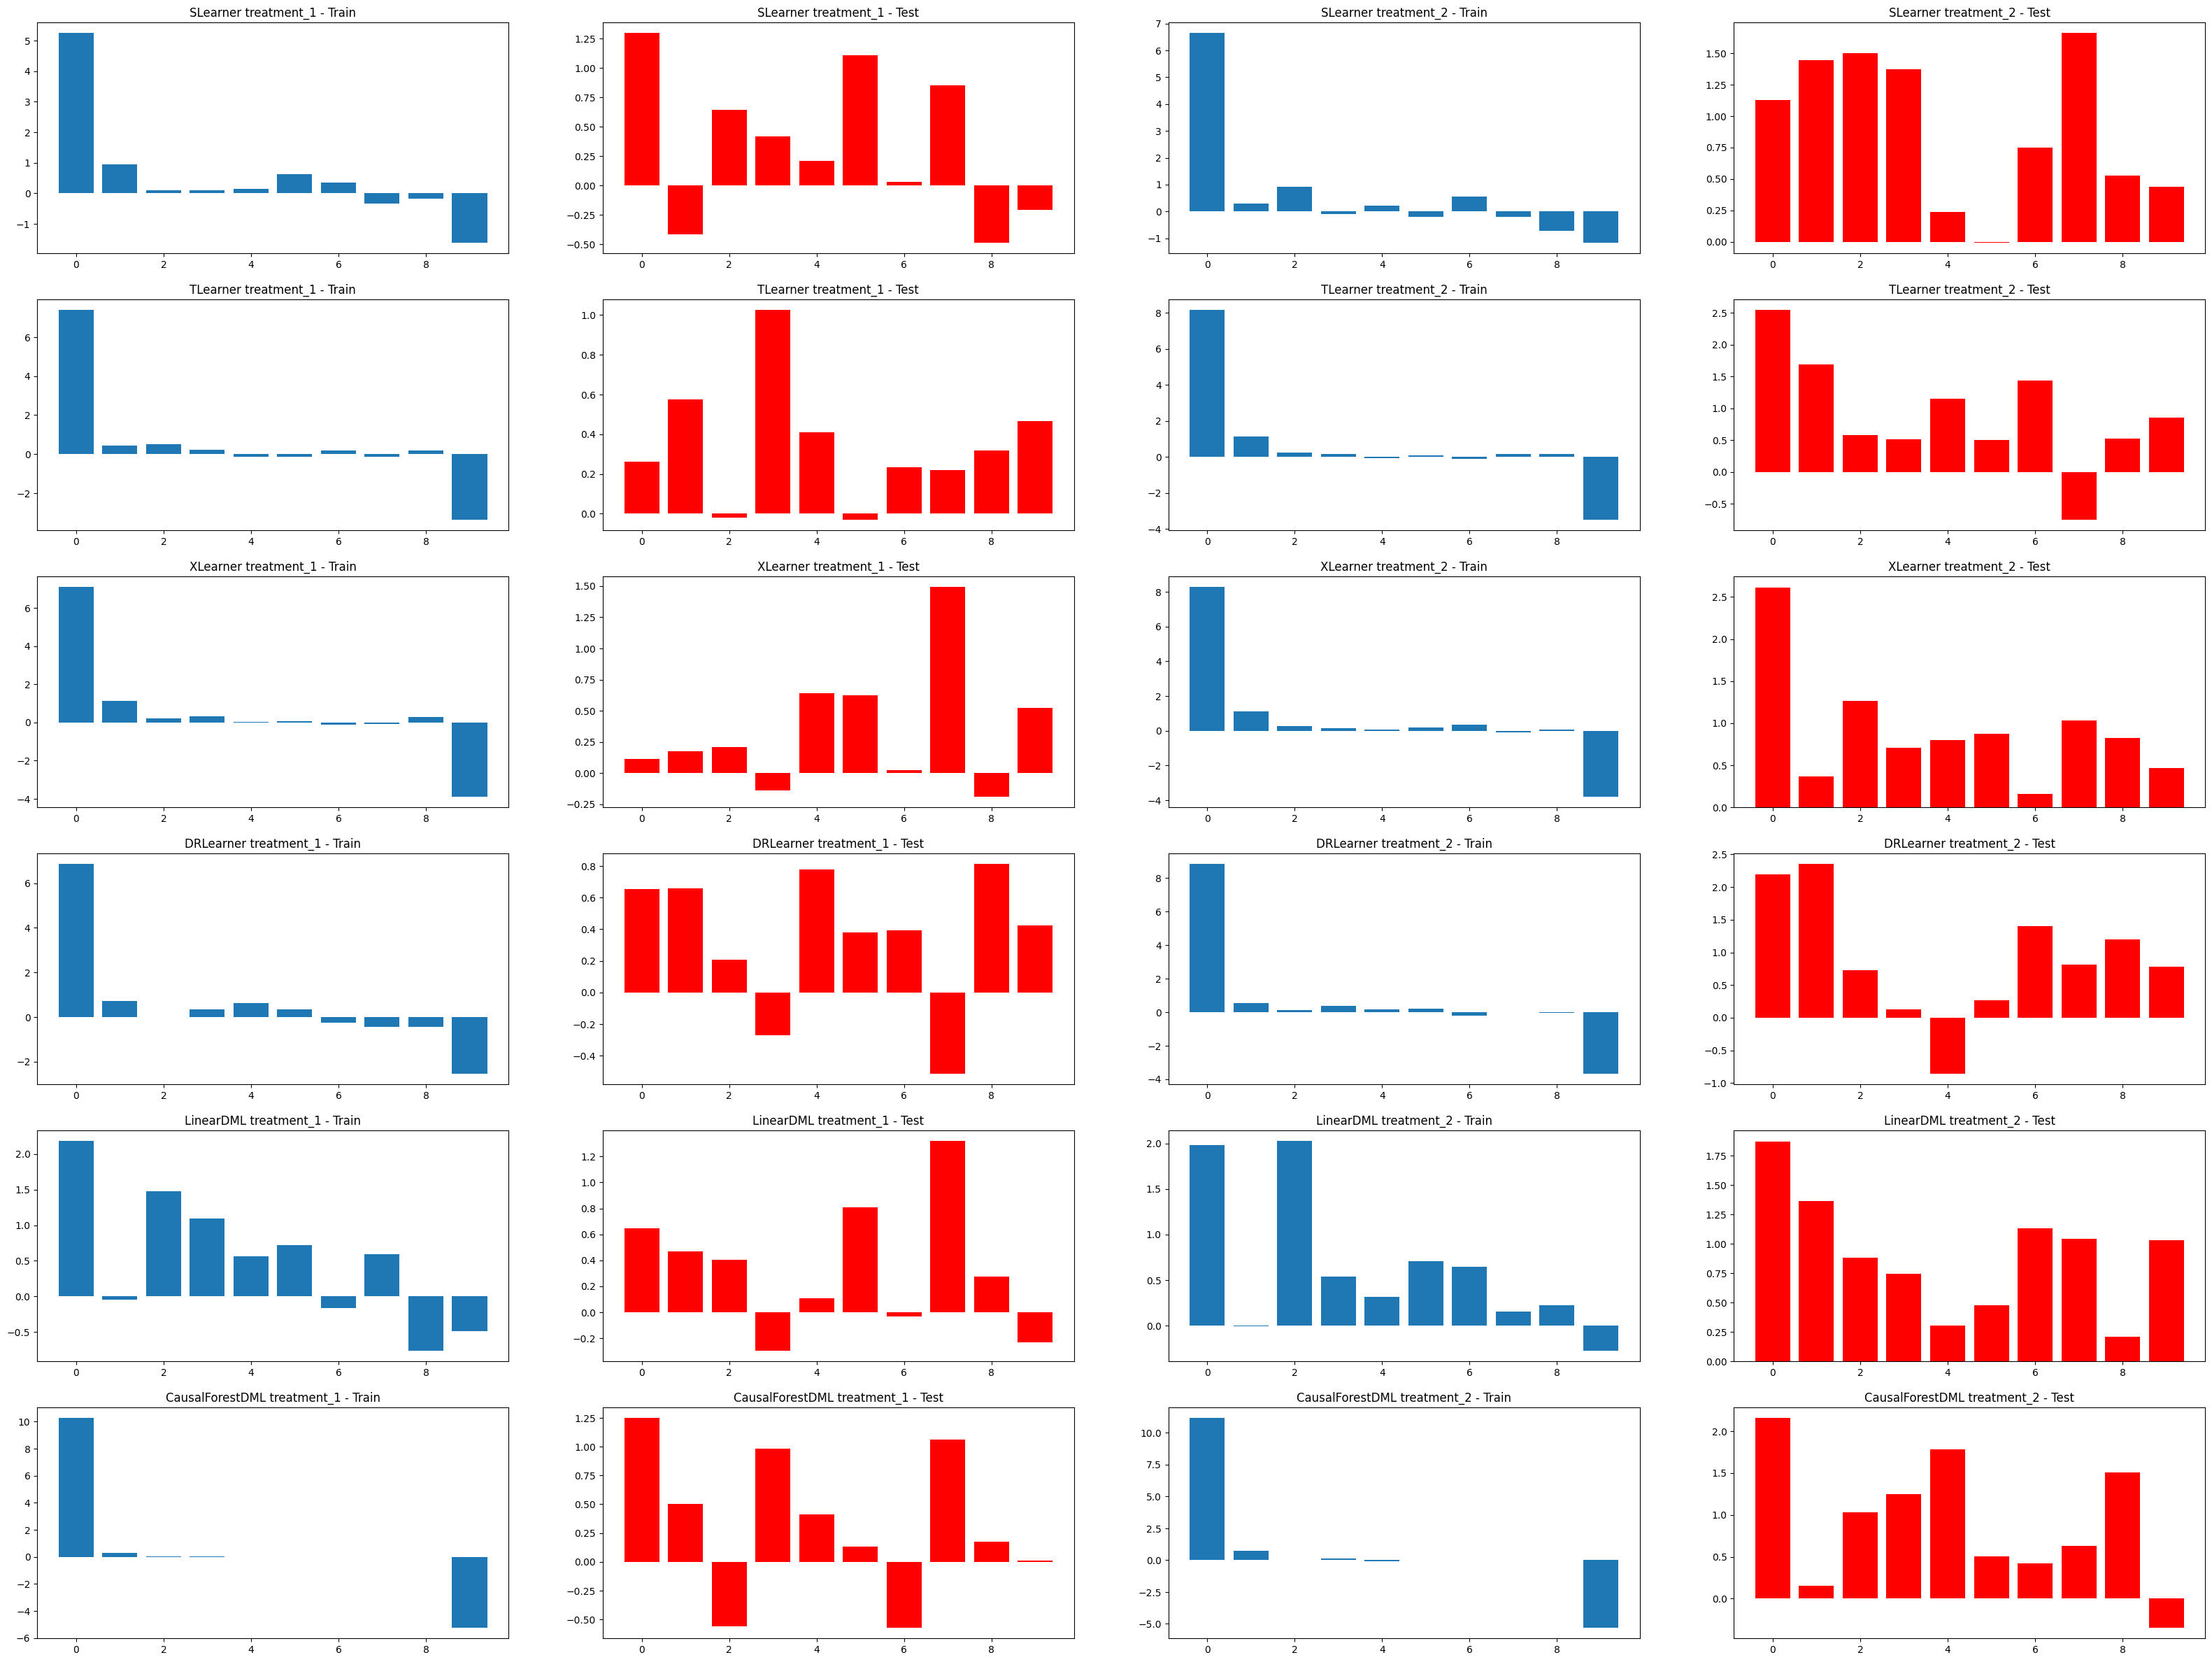

In [74]:
plt.figure(figsize=(40, 30))
i = 1

for model_name in models.keys():
    uplifts_by_decile = {
        "treatment_1": {},
        "treatment_2": {}
    }

    global_min = np.inf
    global_max = -np.inf

    for treatment in ["treatment_1", "treatment_2"]:
        uplifts_by_decile_train = get_uplift_by_decile(
            uplifts=effects_train[treatment][model_name],
            t_true=T_train,
            t_pred=int(treatment.split("_")[1]),
            y_true=y_train
        )

        uplifts_by_decile_test = get_uplift_by_decile(
            uplifts=effects_test[treatment][model_name],
            t_true=T_test,
            t_pred=int(treatment.split("_")[1]),
            y_true=y_test
        )

        plt.subplot(6, 4, i)
        plt.bar(np.arange(10), uplifts_by_decile_train)
        plt.title(f"{model_name} {treatment} - Train")

        plt.subplot(6, 4, i + 1)
        plt.bar(np.arange(10), uplifts_by_decile_test, color="red")
        plt.title(f"{model_name} {treatment} - Test")

        i += 2

plt.show()
